<h1>Sam Armstrong Assignment 3 CS545</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
import pandas

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import neuralnetworks as nn
# import optimizers as opt  # from Lecture Notes

In [3]:
class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False, use_gpu=False):

        # Force n_hidens_list to be a list
        if(torch.cuda.is_available() and use_gpu):
            torch.set_default_tensor_type('torch.cuda.FloatTensor')
        else:
            torch.set_default_tensor_type('torch.FloatTensor')
            
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 
        # Call the constructor for NeuralNetwork, passing in the number of unique class names (ints)
        # as the number of outputs
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)

        # Store as member variables other things needed by instances of this class.
        
        self.classes = np.array(classes) # to allow argmax in use()
        
        if use_torch:
            self.log = torch.log
            self.exp = torch.exp
            self.sum = torch.sum
            self.unique = torch.unique
            self.mean = torch.mean
            self.tanh = torch.tanh
        else:
            self.log = np.log
            self.exp = np.exp
            self.sum = np.sum
            self.unique = np.unique
            self.mean = np.mean
            self.tanh = np.tanh
    

    def makeIndicatorVars(self, T):
        # Make sure T is two-dimensiona. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1,1))
        return (T == np.unique(T)).astype(int)
    
    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.classes}, use_torch={self.use_torch})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
    
    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1
            
    def _standardizeX(self, X):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
            if not isinstance(self.Xmeans, torch.Tensor):
                self.Xmeans = torch.tensor(self.Xmeans, dtype=torch.float) 
            if not isinstance(self.XstdsFixed, torch.Tensor):
                self.XstdsFixed = torch.tensor(self.XstdsFixed, dtype=torch.float) 
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans
    
    def _standardizeT(self, T):
        return T

    def _unstandardizeT(self, Ts):
        return Ts

    def _forward_pass(self, X):
        # Assume weights already unpacked
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float) 
        Z_prev = X  # output of previous layer
        Z = [Z_prev]
        for i in range(self.n_hidden_layers):
            V = self.Vs[i]
            Z_prev = self.tanh(Z_prev @ V[1:, :] + V[0:1, :])
            Z.append(Z_prev)
        Y = self.exp(Z_prev @ self.W[1:, :] + self.W[0:1, :])
        np.seterr(divide='ignore', invalid='ignore')
        softMax = Y/self.sum(Y, axis=1).reshape(-1, 1)
        return softMax, Z

    def _objectiveF(self, w, X, T):
        self._unpack(w)
        if self.use_torch:
            if not isinstance(T, torch.Tensor):
                T = torch.tensor(T, dtype=torch.float) 
        Y, _ = self._forward_pass(X)
        return -self.mean(T * self.log(Y))

    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)
    
    def train(self, X, T, n_epochs, method='scg',
              verbose=False, save_weights_history=False,
              learning_rate=0.001, momentum_rate=0.0): # only for sgd and adam

        if isinstance(X, torch.Tensor):
            X = X.detach().numpy()
        if isinstance(T, torch.Tensor):
            T = T.detach().numpy()
        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]}) not equal to number of network inputs ({self.n_inputs})')
       
        T = self.makeIndicatorVars(T)
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float)  # 32 bit
            T = torch.tensor(T, dtype=torch.float)

        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
        
        try:
            algo = [opt.sgd, opt.adam, opt.scg][['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            

        result = algo(self._pack(self.Vs, self.W),
                      self._objectiveF,
                      [X, T], n_epochs,
                      self._gradientF,  # not used if scg
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch,
                      save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] # * self.Tstds # to _unstandardize the MSEs
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self

    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        Y_classes = self.classes[np.where((Y == Y.max(axis=1)[:,None]).astype(int) == 1)[1].reshape(-1, 1)]
        return (Y_classes, Y, Z[1:]) if all_outputs else (Y_classes, Y)

In [4]:
np.random.seed(42)
X = np.arange(20).reshape((10, 2)) * 0.1
T = np.hstack((X[:, 0:1]**2, np.sin(X[:, 1:2])))
X.shape, T.shape

((10, 2), (10, 2))

In [5]:
X

array([[0. , 0.1],
       [0.2, 0.3],
       [0.4, 0.5],
       [0.6, 0.7],
       [0.8, 0.9],
       [1. , 1.1],
       [1.2, 1.3],
       [1.4, 1.5],
       [1.6, 1.7],
       [1.8, 1.9]])

In [6]:
T

array([[0.        , 0.09983342],
       [0.04      , 0.29552021],
       [0.16      , 0.47942554],
       [0.36      , 0.64421769],
       [0.64      , 0.78332691],
       [1.        , 0.89120736],
       [1.44      , 0.96355819],
       [1.96      , 0.99749499],
       [2.56      , 0.99166481],
       [3.24      , 0.94630009]])

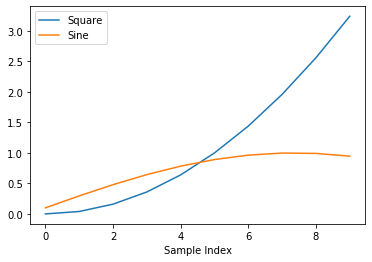

In [7]:
plt.plot(T)
plt.xlabel('Sample Index')
plt.legend(['Square', 'Sine']);

In [8]:
nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)  Network is not trained.

In [9]:
nnet.train(X, T, 50, method='scg')
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0259 seconds. Final objective value is 0.074

[0.74073085 0.4984492  0.35925009 0.24158265 0.23289625 0.22811977
 0.22337226 0.21922631 0.214916   0.21069511 0.20630379 0.20195649
 0.19745231 0.19297383 0.18836311 0.18377552 0.17908898 0.17443355
 0.16971839 0.16504905 0.1603623  0.15574006 0.15114304 0.14663113
 0.14218485 0.13784436 0.13360544 0.12949131 0.12550829 0.12166561
 0.11797588 0.11443709 0.11106465 0.10784783 0.10480237 0.10191108
 0.09918858 0.09661318 0.0941978  0.09191805 0.0897852  0.0877736
 0.08589326 0.08411848 0.08245854 0.0808885  0.07941738 0.07802156
 0.07671011 0.075461   0.07428353]


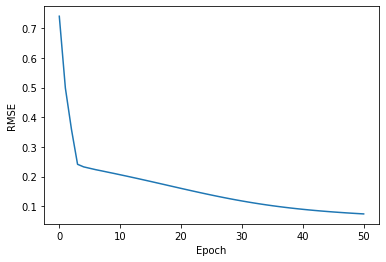

In [10]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');
print(nnet.get_error_trace())

In [11]:
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0259 seconds. Final objective value is 0.074

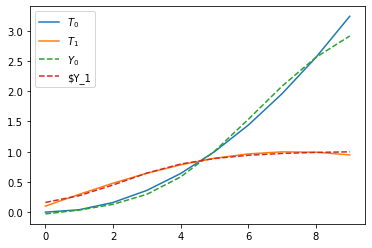

In [12]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0119 seconds. Final objective value is 0.212


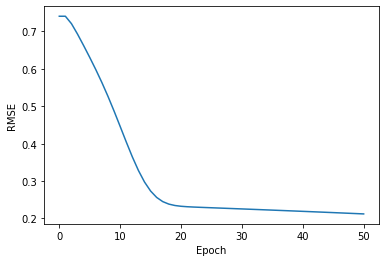

In [13]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet.train(X, T, 50, method='sgd', learning_rate=0.1, momentum_rate=0.5)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

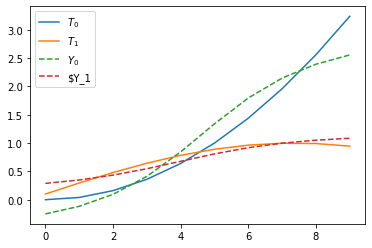

In [14]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0139 seconds. Final objective value is 0.037


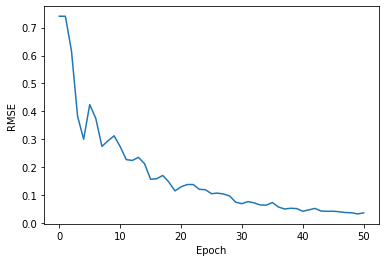

In [15]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet.train(X, T, 50, method='adam', learning_rate=0.1)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

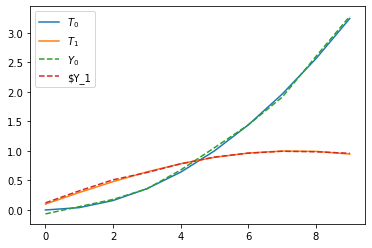

In [16]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

NeuralNetwork(2, [10, 10], 2, use_torch=True)
   Network was trained for 50 epochs that took 0.1495 seconds. Final objective value is 0.036


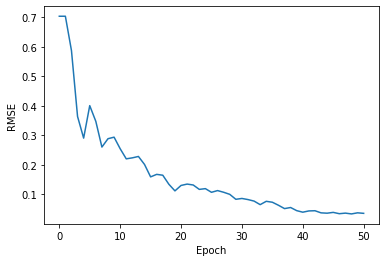

In [17]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2, use_torch=True)
nnet.train(X, T, 50, method='adam', learning_rate=0.1)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

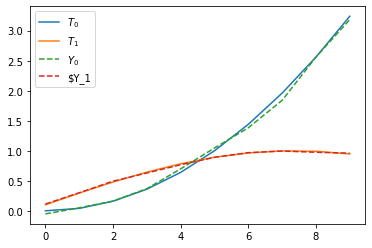

In [18]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

In [19]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

n_samples = 20
X = np.random.choice(3, (n_samples, 2))
T = (X[:, 0:1] == X[:, 1:2]).astype(int)  # where the two inputs are equal
classes = [0, 1]

for x, t in zip(X, T):
    print(f'x = {x}, t = {t}')

x = [2 0], t = [0]
x = [2 2], t = [1]
x = [0 0], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [2 2], t = [1]
x = [0 2], t = [0]
x = [1 0], t = [0]
x = [1 1], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [0 2], t = [0]
x = [2 2], t = [1]
x = [1 2], t = [0]
x = [1 1], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [0 2], t = [0]


In [20]:
print(f'{np.sum(T==0)} not equal, {np.sum(T==1)} equal')

8 not equal, 12 equal


In [21]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1])
nnet_new

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=False)  Network is not trained.

In [22]:
nnet_new._standardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [23]:
nnet_new._unstandardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [24]:
nnet_new._setup_standardize(X, T)
Xst = nnet_new._standardizeX(X)
Xst

array([[ 1.08347268, -1.47709789],
       [ 1.08347268,  0.98473193],
       [-1.32424438, -1.47709789],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193],
       [-0.12038585, -1.47709789],
       [-0.12038585, -0.24618298],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-1.32424438,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-0.12038585,  0.98473193],
       [-0.12038585, -0.24618298],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193]])

In [25]:
Y, Z = nnet_new._forward_pass(Xst)
Y

array([[0.55163905, 0.44836095],
       [0.52855705, 0.47144295],
       [0.59590952, 0.40409048],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539],
       [0.57163885, 0.42836115],
       [0.56395347, 0.43604653],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.59746461, 0.40253539],
       [0.52855705, 0.47144295],
       [0.56007003, 0.43992997],
       [0.56395347, 0.43604653],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539]])

In [26]:
w = nnet_new._pack(nnet_new.Vs, nnet_new.W)

T_indicator_vars = np.hstack((1 - T, T))  # this only works for this particular two-class toy data

nnet_new._objectiveF(w, X, T_indicator_vars)

0.3525328777771416

In [27]:
nnet_new.train(X, T, 100)

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=False)
   Network was trained for 66 epochs that took 0.0367 seconds. Final objective value is 1.000

In [28]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

((20, 1), (20, 2))

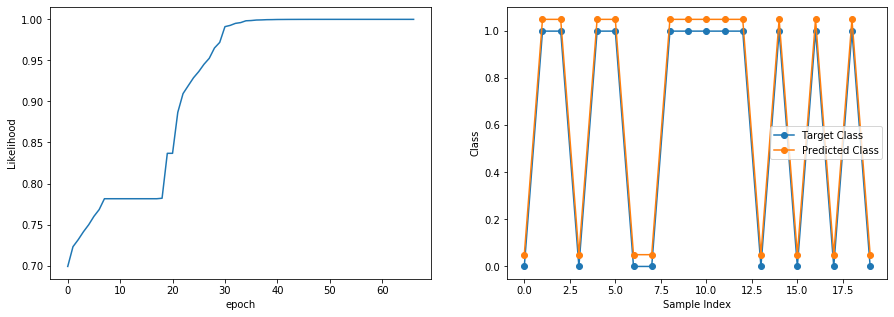

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

<h2>Real Data Set</h2>

In [30]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00312/dow_jones_index.zip
# !unzip dow_jones_index.zip

In [31]:
data = pandas.read_csv('dow_jones_index.data').fillna(0.0).drop(['date'], axis=1)
data[['open','high','low','close','next_weeks_open','next_weeks_close']] = data[['open','high','low','close','next_weeks_open','next_weeks_close']].replace('[\$,]', '', regex=True).astype(float)
classes = np.unique(data.as_matrix(columns=['stock']))
data_X = data[['quarter','open','high','low','close','volume','percent_change_price','percent_change_volume_over_last_wk','previous_weeks_volume','next_weeks_open','next_weeks_close','percent_change_next_weeks_price','days_to_next_dividend','percent_return_next_dividend']]
X = np.array(data_X)
stock = data['stock']
T = np.array(stock).reshape(-1, 1)
data

/usr/local/anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,quarter,stock,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,15.82,16.72,15.78,16.42,239655616,3.79267,0.000000,0.0,16.71,15.97,-4.428490,26,0.182704
1,1,AA,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
2,1,AA,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
3,1,AA,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
4,1,AA,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,80.22,82.63,80.07,82.63,68230855,3.00424,-21.355713,86758820.0,83.28,81.18,-2.521610,75,0.568801
746,2,XOM,83.28,83.75,80.18,81.18,78616295,-2.52161,15.221032,68230855.0,80.93,79.78,-1.420980,68,0.578960
747,2,XOM,80.93,81.87,79.72,79.78,92380844,-1.42098,17.508519,78616295.0,80.00,79.02,-1.225000,61,0.589120
748,2,XOM,80.00,80.82,78.33,79.02,100521400,-1.22500,8.811952,92380844.0,78.65,76.78,-2.377620,54,0.594786


<h2>Different Sized Networks</h2>

<h3>Network 1 [30, 30]</h3>

In [32]:
dj_nnet1_scg = NeuralNetworkClassifier(14, [30, 30], classes)
dj_nnet1_adam = NeuralNetworkClassifier(14, [30, 30], classes)
dj_nnet1_sgd = NeuralNetworkClassifier(14, [30, 30], classes)
dj_nnet1_scg

NeuralNetworkClassifier(14, [30, 30], ['AA' 'AXP' 'BA' 'BAC' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'HPQ' 'IBM'
 'INTC' 'JNJ' 'JPM' 'KO' 'KRFT' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T'
 'TRV' 'UTX' 'VZ' 'WMT' 'XOM'], use_torch=False)  Network is not trained.

In [33]:
dj_nnet1_scg.train(X, T, 1400, method='scg', verbose=True)
dj_nnet1_adam.train(X, T, 800, method='adam', verbose=True, learning_rate= 0.1)
dj_nnet1_sgd.train(X, T, 3000, method='sgd', verbose=True, learning_rate= 2.0)
dj_nnet1_scg

SCG: Iteration 140 ObjectiveF=0.99720 Scale=1.000e-15 Seconds=0.422
SCG: Iteration 280 ObjectiveF=0.99833 Scale=1.000e-15 Seconds=0.486
SCG: Iteration 420 ObjectiveF=0.99888 Scale=1.000e-15 Seconds=0.428
SCG: Iteration 560 ObjectiveF=0.99920 Scale=1.000e-15 Seconds=0.386
SCG: Iteration 700 ObjectiveF=0.99943 Scale=1.000e-15 Seconds=0.410
SCG: Iteration 840 ObjectiveF=0.99961 Scale=1.000e-15 Seconds=0.406
SCG: Iteration 980 ObjectiveF=0.99970 Scale=1.000e-15 Seconds=0.429
SCG: Iteration 1120 ObjectiveF=0.99977 Scale=1.000e-15 Seconds=0.388
SCG: Iteration 1260 ObjectiveF=0.99985 Scale=1.000e-15 Seconds=0.416
SCG: Iteration 1400 ObjectiveF=0.99988 Scale=1.000e-15 Seconds=0.395
adam: Iteration 80 ObjectiveF=0.99981 Seconds=0.113
adam: Iteration 160 ObjectiveF=0.99996 Seconds=0.117
adam: Iteration 240 ObjectiveF=0.99998 Seconds=0.111
adam: Iteration 320 ObjectiveF=0.99999 Seconds=0.114
adam: Iteration 400 ObjectiveF=0.99999 Seconds=0.112
adam: Iteration 480 ObjectiveF=0.99999 Seconds=0.117


NeuralNetworkClassifier(14, [30, 30], ['AA' 'AXP' 'BA' 'BAC' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'HPQ' 'IBM'
 'INTC' 'JNJ' 'JPM' 'KO' 'KRFT' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T'
 'TRV' 'UTX' 'VZ' 'WMT' 'XOM'], use_torch=False)
   Network was trained for 1400 epochs that took 4.1672 seconds. Final objective value is 1.000

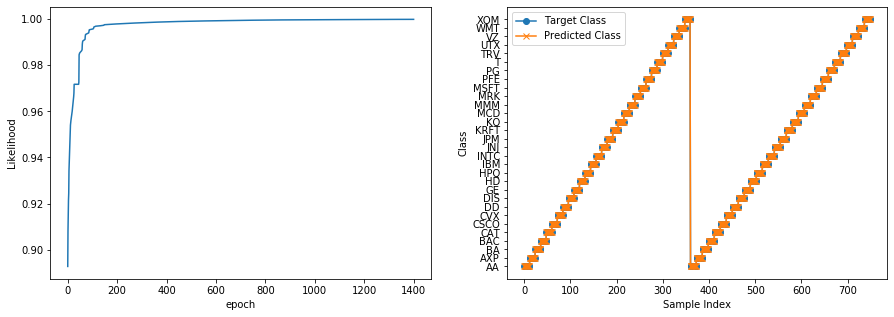

In [34]:
Y_classes1, Y1 = dj_nnet1_scg.use(X)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(dj_nnet1_scg.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T.reshape(-1), 'o-')
plt.plot(Y_classes1.reshape(-1), 'x-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

<h3>Network 2 [20, 20]</h3>

In [35]:
dj_nnet2_scg = NeuralNetworkClassifier(14, [20, 20], classes)
dj_nnet2_adam = NeuralNetworkClassifier(14, [20, 20], classes)
dj_nnet2_sgd = NeuralNetworkClassifier(14, [20, 20], classes)
dj_nnet2_scg

NeuralNetworkClassifier(14, [20, 20], ['AA' 'AXP' 'BA' 'BAC' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'HPQ' 'IBM'
 'INTC' 'JNJ' 'JPM' 'KO' 'KRFT' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T'
 'TRV' 'UTX' 'VZ' 'WMT' 'XOM'], use_torch=False)  Network is not trained.

In [36]:
dj_nnet2_scg.train(X, T, 2000, method='scg', verbose=True)
dj_nnet2_adam.train(X, T, 1000, method='adam', verbose=True, learning_rate= 0.1)
dj_nnet2_sgd.train(X, T, 3000, method='sgd', verbose=True, learning_rate= 2.0)
dj_nnet2_scg

SCG: Iteration 200 ObjectiveF=0.99372 Scale=1.000e-15 Seconds=0.511
SCG: Iteration 400 ObjectiveF=0.99902 Scale=1.000e-15 Seconds=0.547
SCG: Iteration 600 ObjectiveF=0.99953 Scale=1.000e-15 Seconds=0.541
SCG: Iteration 800 ObjectiveF=0.99990 Scale=1.000e-15 Seconds=0.564
SCG: Iteration 1000 ObjectiveF=0.99995 Scale=1.000e-15 Seconds=0.521
SCG: Iteration 1200 ObjectiveF=0.99997 Scale=1.000e-15 Seconds=0.526
SCG: Iteration 1400 ObjectiveF=0.99999 Scale=1.000e-15 Seconds=0.524
SCG: Iteration 1600 ObjectiveF=1.00000 Scale=1.000e-15 Seconds=0.548
SCG: Iteration 1800 ObjectiveF=1.00000 Scale=1.000e-15 Seconds=0.530
SCG: Iteration 2000 ObjectiveF=1.00000 Scale=1.000e-15 Seconds=0.532
adam: Iteration 100 ObjectiveF=0.99989 Seconds=0.154
adam: Iteration 200 ObjectiveF=0.99996 Seconds=0.151
adam: Iteration 300 ObjectiveF=0.99998 Seconds=0.148
adam: Iteration 400 ObjectiveF=0.99998 Seconds=0.150
adam: Iteration 500 ObjectiveF=0.99999 Seconds=0.155
adam: Iteration 600 ObjectiveF=0.99999 Seconds=0.

NeuralNetworkClassifier(14, [20, 20], ['AA' 'AXP' 'BA' 'BAC' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'HPQ' 'IBM'
 'INTC' 'JNJ' 'JPM' 'KO' 'KRFT' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T'
 'TRV' 'UTX' 'VZ' 'WMT' 'XOM'], use_torch=False)
   Network was trained for 2000 epochs that took 5.3466 seconds. Final objective value is 1.000

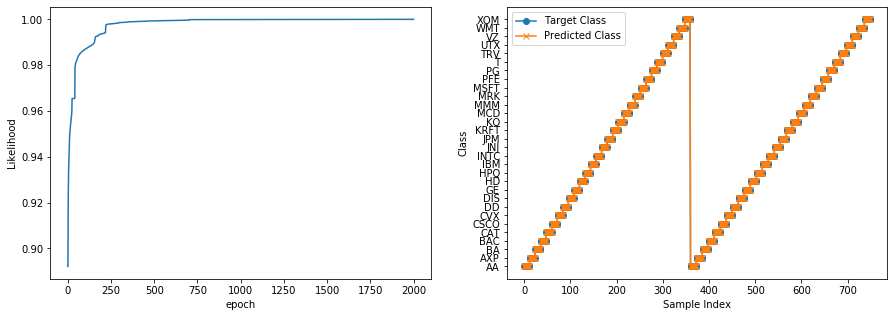

In [37]:
Y_classes2, Y2 = dj_nnet2_scg.use(X)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(dj_nnet2_scg.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T.reshape(-1), 'o-')
plt.plot(Y_classes2.reshape(-1), 'x-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

<h3>Network 3 [10, 10]</h3>

In [38]:
dj_nnet3_scg = NeuralNetworkClassifier(14, [10, 10], classes)
dj_nnet3_adam = NeuralNetworkClassifier(14, [10, 10], classes)
dj_nnet3_sgd = NeuralNetworkClassifier(14, [10, 10], classes)
dj_nnet3_scg

NeuralNetworkClassifier(14, [10, 10], ['AA' 'AXP' 'BA' 'BAC' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'HPQ' 'IBM'
 'INTC' 'JNJ' 'JPM' 'KO' 'KRFT' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T'
 'TRV' 'UTX' 'VZ' 'WMT' 'XOM'], use_torch=False)  Network is not trained.

In [39]:
dj_nnet3_scg.train(X, T, 4000, method='scg', verbose=True)
dj_nnet3_adam.train(X, T, 4000, method='adam', verbose=True, learning_rate= 0.1)
dj_nnet3_sgd.train(X, T, 4000, method='sgd', verbose=True, learning_rate= 2.0)
dj_nnet3_scg

SCG: Iteration 400 ObjectiveF=0.99336 Scale=1.000e-15 Seconds=1.395
SCG: Iteration 800 ObjectiveF=0.99755 Scale=1.000e-15 Seconds=1.419
SCG: Iteration 1200 ObjectiveF=0.99847 Scale=1.000e-15 Seconds=1.447
SCG: Iteration 1600 ObjectiveF=0.99896 Scale=1.000e-15 Seconds=1.411
SCG: Iteration 2000 ObjectiveF=0.99968 Scale=1.000e-15 Seconds=1.438
SCG: Iteration 2400 ObjectiveF=0.99971 Scale=1.000e-15 Seconds=1.417
SCG: Iteration 2800 ObjectiveF=0.99973 Scale=1.000e-15 Seconds=1.422
SCG: Iteration 3200 ObjectiveF=0.99976 Scale=1.000e-15 Seconds=1.414
SCG: Iteration 3600 ObjectiveF=0.99979 Scale=1.000e-15 Seconds=1.416
SCG: Iteration 4000 ObjectiveF=0.99982 Scale=1.000e-15 Seconds=1.414
adam: Iteration 400 ObjectiveF=0.99977 Seconds=0.709
adam: Iteration 800 ObjectiveF=0.99967 Seconds=0.725
adam: Iteration 1200 ObjectiveF=0.99988 Seconds=0.712
adam: Iteration 1600 ObjectiveF=0.99998 Seconds=0.743
adam: Iteration 2000 ObjectiveF=0.99999 Seconds=0.703
adam: Iteration 2400 ObjectiveF=0.99999 Seco

NeuralNetworkClassifier(14, [10, 10], ['AA' 'AXP' 'BA' 'BAC' 'CAT' 'CSCO' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'HPQ' 'IBM'
 'INTC' 'JNJ' 'JPM' 'KO' 'KRFT' 'MCD' 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T'
 'TRV' 'UTX' 'VZ' 'WMT' 'XOM'], use_torch=False)
   Network was trained for 4000 epochs that took 14.1949 seconds. Final objective value is 1.000

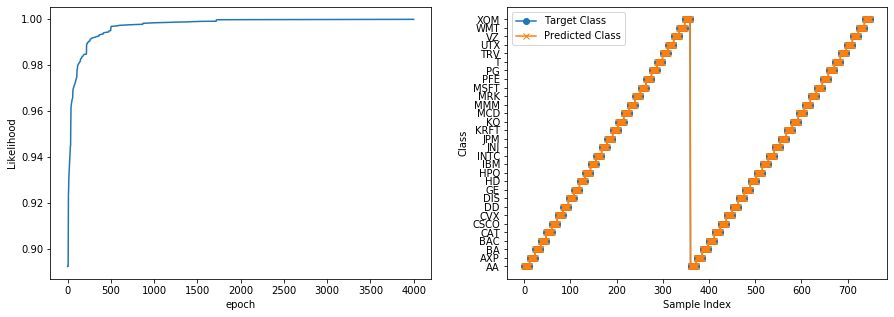

In [40]:
Y_classes3, Y3 = dj_nnet3_scg.use(X)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(dj_nnet3_scg.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T.reshape(-1), 'o-')
plt.plot(Y_classes3.reshape(-1), 'x-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

<h2>Discussion</h2>

The dataset I choose are the stocks that make up the Dow Jones Index. There are 30 different stocks each with 14 different attributes and 750 total samples (duplicate stocks were recorded at different points in time). I used three different sized networks Network1 [30, 30], Network2 [20, 20], and Network 3 [10, 10]. I choose these 3 different sizes because I wanted to test if the size of the hidden layers needs to be at least the size of the number of classes. 

Network1 performed the best with the fastest increase in the objective function. Network1's best performing training was Adam (able to train to an objective function of 1.0 in 800 epochs), its second best performing training was SCG (able to train to an objective function of 1.0 in 1400 epochs), and its worst performing training was SGD (able to train to an objective function of 0.99 in 3000 epochs). Network1 was not able to reach an objective function of 1.0 using SGD with 3000 or less epochs. 

Network2 was the second best performing network with the second fastest increasing objective function. Network2's best performing training was Adam (able to train to an objective function of 1.0 in 900 epochs), its second best performing training was SCG (able to train to an objective function of 1.0 in 2000 epochs), and its worst performing training was SGD (able to train to an objective function of 0.99 in 3000 epochs). Reducing the hidden layers from 30 to 20 increased the amount of epochs needed to train SCG and Adam to the same objective function of 1.0, but they were still able to reach the objective function of 1.0. Network2 was not able to reach an objective function of 1.0 using SGD with 3000 or less epochs. 

Network3 performed the worst with the slowest increasing objective function. Network3's best performing training was Adam (able to train to an objective function of 1.0 in 2400 epochs), its second best performing training was SCG (able to train to an objective function of 0.999 in 4000 epochs), and its worst performing training was SGD (able to train to an objective function of 0.98 in 4000 epochs). Reducing the hidden layers from 20 to 10 again increased the amount of epochs needed to train Adam to the same objective function of 1.0, but Adam was still able to reach the objective function of 1.0. Network3 was not able to reach an objective function of 1.0 using SCG or SGD using 4000 or less epochs. 

Although using the same size of the hidden layers as number of classes (30) performed the best, reducing the size of the hidden layers didn't limit the objective function to lower than 1.0. Adam consistently trained the best on all three Networks, follwed by SCG and than SGD. The step size of Adam was set to 0.1 and the step size of SGD was set to 2.0 for all the trainings. Using a step size of 2.0 for SGD seemed large, but using a step size of 0.1 resulted in the model training way to slow.

<h2>Extra Credit 1</h2>

In [41]:
I = {}
for s in classes:
    temp, _ = np.where(T == s)
    I[s] = np.random.permutation(temp)

N = {}
for x, y in I.items():
    N[x] = round(0.8*len(y))

Ltrain = [] 
Ltest = []  
for s2 in classes:
    Ltrain.append(I[s2][:N[s2]])
    Ltest.append(I[s2][N[s2]:])   
    
rowsTrain = np.hstack(Ltrain)
Xtrain = X[rowsTrain, :]
Ttrain = T[rowsTrain, :]
rowsTest = np.hstack(Ltest)
Xtest =  X[rowsTest, :]
Ttest =  T[rowsTest, :]

<h3>Network 1 [30, 30] SCG</h3>

In [42]:
par_nnet1_scg = NeuralNetworkClassifier(14, [30, 30], classes)
par_nnet1_scg.train(Xtrain, Ttrain, 500, method='scg', verbose=True)
Yc, Y = par_nnet1_scg.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet1_scg.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

SCG: Iteration 50 ObjectiveF=0.97244 Scale=1.192e-13 Seconds=0.134
SCG: Iteration 100 ObjectiveF=0.99631 Scale=1.000e-15 Seconds=0.146
SCG: Iteration 150 ObjectiveF=0.99886 Scale=1.000e-15 Seconds=0.146
SCG: Iteration 200 ObjectiveF=0.99912 Scale=1.000e-15 Seconds=0.148
SCG: Iteration 250 ObjectiveF=0.99924 Scale=1.000e-15 Seconds=0.146
SCG: Iteration 300 ObjectiveF=0.99957 Scale=1.000e-15 Seconds=0.146
SCG: Iteration 350 ObjectiveF=0.99961 Scale=1.000e-15 Seconds=0.146
SCG: Iteration 400 ObjectiveF=0.99964 Scale=1.000e-15 Seconds=0.133
SCG: Iteration 450 ObjectiveF=0.99967 Scale=1.000e-15 Seconds=0.135
SCG: Iteration 500 ObjectiveF=0.99970 Scale=1.000e-15 Seconds=0.146
Training data 600 out of 600 samples, or 100.00 percent.
Testing Data 147 out of 150 samples, or 98.00 percent.


<h3>Network 1 [30, 30] Adam</h3>

In [43]:
par_nnet1_adam = NeuralNetworkClassifier(14, [30, 30], classes)
par_nnet1_adam.train(Xtrain, Ttrain, 500, method='adam', verbose=True, learning_rate= 0.1)
Yc, Y = par_nnet1_adam.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet1_adam.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

adam: Iteration 50 ObjectiveF=0.99963 Seconds=0.071
adam: Iteration 100 ObjectiveF=0.99993 Seconds=0.065
adam: Iteration 150 ObjectiveF=0.99996 Seconds=0.064
adam: Iteration 200 ObjectiveF=0.99997 Seconds=0.067
adam: Iteration 250 ObjectiveF=0.99998 Seconds=0.069
adam: Iteration 300 ObjectiveF=0.99998 Seconds=0.067
adam: Iteration 350 ObjectiveF=0.99999 Seconds=0.064
adam: Iteration 400 ObjectiveF=0.99999 Seconds=0.067
adam: Iteration 450 ObjectiveF=0.99999 Seconds=0.066
adam: Iteration 500 ObjectiveF=0.99999 Seconds=0.066
Training data 600 out of 600 samples, or 100.00 percent.
Testing Data 145 out of 150 samples, or 96.67 percent.


<h3>Network 1 [30, 30] SGD</h3>

In [44]:
par_nnet1_sgd = NeuralNetworkClassifier(14, [30, 30], classes)
par_nnet1_sgd.train(Xtrain, Ttrain, 2000, method='sgd', verbose=True, learning_rate= 2.0)
Yc, Y = par_nnet1_sgd.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet1_sgd.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

sgd: Iteration 200 ObjectiveF=0.92458 Seconds=0.292
sgd: Iteration 400 ObjectiveF=0.94830 Seconds=0.249
sgd: Iteration 600 ObjectiveF=0.96197 Seconds=0.249
sgd: Iteration 800 ObjectiveF=0.97082 Seconds=0.248
sgd: Iteration 1000 ObjectiveF=0.97711 Seconds=0.273
sgd: Iteration 1200 ObjectiveF=0.98176 Seconds=0.341
sgd: Iteration 1400 ObjectiveF=0.98519 Seconds=0.284
sgd: Iteration 1600 ObjectiveF=0.98773 Seconds=0.246
sgd: Iteration 1800 ObjectiveF=0.98964 Seconds=0.245
sgd: Iteration 2000 ObjectiveF=0.99110 Seconds=0.247
Training data 582 out of 600 samples, or 97.00 percent.
Testing Data 145 out of 150 samples, or 96.67 percent.


<h3>Network 2 [20, 20] SCG</h3>

In [45]:
par_nnet2_scg = NeuralNetworkClassifier(14, [20, 20], classes)
par_nnet2_scg.train(Xtrain, Ttrain, 1000, method='scg', verbose=True)
Yc, Y = par_nnet2_scg.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet2_scg.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

SCG: Iteration 100 ObjectiveF=0.99659 Scale=1.000e-15 Seconds=0.237
SCG: Iteration 200 ObjectiveF=0.99789 Scale=1.000e-15 Seconds=0.230
SCG: Iteration 300 ObjectiveF=0.99839 Scale=1.000e-15 Seconds=0.229
SCG: Iteration 400 ObjectiveF=0.99875 Scale=1.000e-15 Seconds=0.230
SCG: Iteration 500 ObjectiveF=0.99903 Scale=1.000e-15 Seconds=0.231
SCG: Iteration 600 ObjectiveF=0.99922 Scale=1.000e-15 Seconds=0.255
SCG: Iteration 700 ObjectiveF=0.99961 Scale=1.000e-15 Seconds=0.231
SCG: Iteration 800 ObjectiveF=0.99965 Scale=1.000e-15 Seconds=0.247
SCG: Iteration 900 ObjectiveF=0.99969 Scale=1.000e-15 Seconds=0.232
SCG: Iteration 1000 ObjectiveF=0.99972 Scale=1.000e-15 Seconds=0.230
Training data 600 out of 600 samples, or 100.00 percent.
Testing Data 146 out of 150 samples, or 97.33 percent.


<h3>Network 2 [20, 20] Adam</h3>

In [46]:
par_nnet2_adam = NeuralNetworkClassifier(14, [20, 20], classes)
par_nnet2_adam.train(Xtrain, Ttrain, 1000, method='adam', verbose=True, learning_rate= 0.1)
Yc, Y = par_nnet2_adam.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet2_adam.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

adam: Iteration 100 ObjectiveF=0.99987 Seconds=0.119
adam: Iteration 200 ObjectiveF=0.99995 Seconds=0.124
adam: Iteration 300 ObjectiveF=0.99997 Seconds=0.130
adam: Iteration 400 ObjectiveF=0.99998 Seconds=0.128
adam: Iteration 500 ObjectiveF=0.99999 Seconds=0.115
adam: Iteration 600 ObjectiveF=0.99999 Seconds=0.114
adam: Iteration 700 ObjectiveF=0.99999 Seconds=0.115
adam: Iteration 800 ObjectiveF=0.99999 Seconds=0.196
adam: Iteration 900 ObjectiveF=1.00000 Seconds=0.255
adam: Iteration 1000 ObjectiveF=1.00000 Seconds=0.245
Training data 600 out of 600 samples, or 100.00 percent.
Testing Data 148 out of 150 samples, or 98.67 percent.


<h3>Network 2 [20, 20] SGD</h3>

In [47]:
par_nnet2_sgd = NeuralNetworkClassifier(14, [20, 20], classes)
par_nnet2_sgd.train(Xtrain, Ttrain, 4000, method='sgd', verbose=True, learning_rate= 2.0)
Yc, Y = par_nnet2_sgd.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet2_sgd.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

sgd: Iteration 400 ObjectiveF=0.93896 Seconds=0.895
sgd: Iteration 800 ObjectiveF=0.96523 Seconds=0.574
sgd: Iteration 1200 ObjectiveF=0.97798 Seconds=0.473
sgd: Iteration 1600 ObjectiveF=0.98501 Seconds=0.459
sgd: Iteration 2000 ObjectiveF=0.98896 Seconds=0.442
sgd: Iteration 2400 ObjectiveF=0.99141 Seconds=0.461
sgd: Iteration 2800 ObjectiveF=0.99309 Seconds=0.466
sgd: Iteration 3200 ObjectiveF=0.99430 Seconds=0.442
sgd: Iteration 3600 ObjectiveF=0.99521 Seconds=0.442
sgd: Iteration 4000 ObjectiveF=0.99591 Seconds=0.442
Training data 591 out of 600 samples, or 98.50 percent.
Testing Data 145 out of 150 samples, or 96.67 percent.


<h3>Network 3 [10, 10] SCG</h3>

In [48]:
par_nnet3_scg = NeuralNetworkClassifier(14, [10, 10], classes)
par_nnet3_scg.train(Xtrain, Ttrain, 1500, method='scg', verbose=True)
Yc, Y = par_nnet3_scg.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet3_scg.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

SCG: Iteration 150 ObjectiveF=0.98906 Scale=1.000e-15 Seconds=0.504
SCG: Iteration 300 ObjectiveF=0.99202 Scale=1.000e-15 Seconds=0.447
SCG: Iteration 450 ObjectiveF=0.99798 Scale=1.000e-15 Seconds=0.470
SCG: Iteration 600 ObjectiveF=0.99883 Scale=1.000e-15 Seconds=0.450
SCG: Iteration 750 ObjectiveF=0.99908 Scale=1.000e-15 Seconds=0.467
SCG: Iteration 900 ObjectiveF=0.99919 Scale=1.000e-15 Seconds=0.463
SCG: Iteration 1050 ObjectiveF=0.99942 Scale=1.000e-15 Seconds=0.500
SCG: Iteration 1200 ObjectiveF=0.99967 Scale=1.000e-15 Seconds=0.447
SCG: Iteration 1350 ObjectiveF=0.99970 Scale=1.000e-15 Seconds=0.446
SCG: Iteration 1500 ObjectiveF=0.99981 Scale=1.000e-15 Seconds=0.447
Training data 600 out of 600 samples, or 100.00 percent.
Testing Data 140 out of 150 samples, or 93.33 percent.


<h3>Network 3 [10, 10] Adam</h3>

In [49]:
par_nnet3_adam = NeuralNetworkClassifier(14, [10, 10], classes)
par_nnet3_adam.train(Xtrain, Ttrain, 1500, method='adam', verbose=True, learning_rate= 0.1)
Yc, Y = par_nnet3_adam.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet3_adam.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

adam: Iteration 150 ObjectiveF=0.99967 Seconds=0.241
adam: Iteration 300 ObjectiveF=0.99991 Seconds=0.244
adam: Iteration 450 ObjectiveF=0.99996 Seconds=0.241
adam: Iteration 600 ObjectiveF=0.99997 Seconds=0.233
adam: Iteration 750 ObjectiveF=0.99998 Seconds=0.242
adam: Iteration 900 ObjectiveF=0.99999 Seconds=0.224
adam: Iteration 1050 ObjectiveF=0.99999 Seconds=0.223
adam: Iteration 1200 ObjectiveF=0.99999 Seconds=0.223
adam: Iteration 1350 ObjectiveF=0.99999 Seconds=0.223
adam: Iteration 1500 ObjectiveF=0.99999 Seconds=0.225
Training data 600 out of 600 samples, or 100.00 percent.
Testing Data 146 out of 150 samples, or 97.33 percent.


<h3>Network 3 [10, 10] SGD</h3>

In [50]:
par_nnet3_sgd = NeuralNetworkClassifier(14, [10, 10], classes)
par_nnet3_sgd.train(Xtrain, Ttrain, 6000, method='sgd', verbose=True, learning_rate= 2.0)
Yc, Y = par_nnet3_sgd.use(Xtrain)
n_correct = (Yc == Ttrain).sum()
print(f'Training data {n_correct} out of {Ttrain.shape[0]} samples, or {n_correct/Ttrain.shape[0]*100:.2f} percent.')
Yc, Y = par_nnet3_sgd.use(Xtest)
n_correct = (Yc == Ttest).sum()
print(f'Testing Data {n_correct} out of {Ttest.shape[0]} samples, or {n_correct/Ttest.shape[0]*100:.2f} percent.')

sgd: Iteration 600 ObjectiveF=0.94099 Seconds=0.881
sgd: Iteration 1200 ObjectiveF=0.96215 Seconds=0.917
sgd: Iteration 1800 ObjectiveF=0.97147 Seconds=0.919
sgd: Iteration 2400 ObjectiveF=0.97778 Seconds=0.906
sgd: Iteration 3000 ObjectiveF=0.98249 Seconds=0.903
sgd: Iteration 3600 ObjectiveF=0.98590 Seconds=0.876
sgd: Iteration 4200 ObjectiveF=0.98831 Seconds=0.876
sgd: Iteration 4800 ObjectiveF=0.99015 Seconds=0.880
sgd: Iteration 5400 ObjectiveF=0.99159 Seconds=0.925
sgd: Iteration 6000 ObjectiveF=0.99275 Seconds=0.877
Training data 578 out of 600 samples, or 96.33 percent.
Testing Data 142 out of 150 samples, or 94.67 percent.


<h2>Discussion Extra Credit 1</h2>

I re-used the three different sized networks Network1 [30, 30], Network2 [20, 20], and Network 3 [10, 10] from the main assignment. I also used the same Dow Jones data (600 training, 150 testing) with an 80/20 split. All of the networks using SCG or Adam got a 600/600 (100%) on the training data. While all the networks using SGD got 580-590/600 (\~97-98%). Suprisingly all of the networks and training methods resulted in an 140-148/150 (~94-98%) success rate on the testing data making it hard to compare them using only one NN initialization. After initializing each network multiple times it seems that the best to worst networks were Network1, Network2, Network3 and that the best to worst training methods were SCG, Adam, SGD based on their testing success rate. The amount of epochs I used on Network 1 for both SCG and Adam was 500 and for SGD it was 2000. The amount of epochs I used on Network 2 for both SCG and Adam was 1000 and for SGD it was 4000. The amount of epochs I used on Network 3 for both SCG and Adam was 1500 and for SGD it was 6000. The reasoning behind increasing the epochs is that the smaller hidden layers neural networks need more training to achieve the same objective function level as the larger hidden layers neural networks.

<h2>Extra Credit 2</h2>
*Had same problem mentioned in class where using the gpu slows down alot in the higher iterations of training

In [51]:
gpu_nnet = NeuralNetworkClassifier(14, [30, 30], classes, use_torch=True, use_gpu=True)
gpu_nnet.train(X, T, 200, method='scg', verbose=True)
Y_classes, Y = gpu_nnet.use(X)

SCG: Iteration 20 ObjectiveF=0.98697 Scale=8.289e-08 Seconds=0.266
SCG: Iteration 40 ObjectiveF=0.99830 Scale=1.581e-13 Seconds=0.596
SCG: Iteration 60 ObjectiveF=0.99945 Scale=1.000e-15 Seconds=0.763
SCG: Iteration 80 ObjectiveF=0.99973 Scale=1.000e-15 Seconds=0.900
SCG: Iteration 100 ObjectiveF=0.99984 Scale=1.000e-15 Seconds=0.660
SCG: Iteration 120 ObjectiveF=0.99991 Scale=2.560e-13 Seconds=0.746
SCG: Iteration 140 ObjectiveF=0.99994 Scale=2.147e-06 Seconds=0.308
SCG: Iteration 160 ObjectiveF=0.99995 Scale=1.342e-07 Seconds=1.263
SCG: Iteration 180 ObjectiveF=0.99996 Scale=6.872e-05 Seconds=1.137
SCG: Iteration 200 ObjectiveF=0.99998 Scale=1.737e-04 Seconds=2.175


In [52]:
# !rm A3grader.zip
# !rm A3grader.py
# !wget https://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.zip
# !unzip A3grader.zip
# %run -i A3grader.py